# Comprehensive PPG Analysis

In this tutorial we will learn how to extract biomarkers from a photoplethysmogram (PPG) signal.

Our objectives are to:

- Detect the standard fiducial points on PPG pulse waves
- Calculate pulse wave biomarkers from the fiducial points
- Saving data in different data format

You can use the sample PPG data by downloading it from the following link: [Sample PPG data](https://github.com/godamartonaron/GODA_pyPPG/blob/main/sample_data/PPG_MAT_sample.mat).


## Setup

Import Python packages:
________________________

- Install the _[pyPPG](https://pyppg.readthedocs.io/)_ toolbox for PPG analysis

In [ ]:
!pip install pyPPG==1.0.36

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 125.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

- Import required components from _pyPPG_

In [ ]:
from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI

- Import other packages

In [ ]:
import numpy as np
import sys
import json
import pandas as pd

Setup input parameters:
_______________________
_The following input parameters are inputs to the `pyPPG.example` module (see the [documentation](https://pyppg.readthedocs.io/en/latest/pyPPG.html#module-pyPPG.example) for further details)._

In [ ]:
data_path = "sample_data/PPG_MAT_sample.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

Load a raw PPG signal:
__________________________

In [ ]:
signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)
signal.v = signal.v [0:20*signal.fs] # 20 second long signal to be analysed

Plot the raw PPG signal:

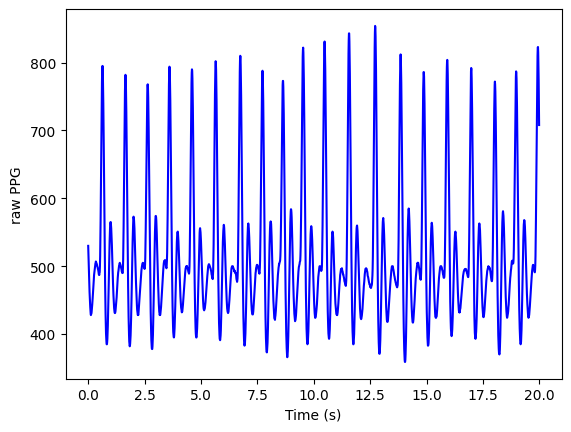

In [ ]:
# import plotting package
from matplotlib import pyplot as plt

# setup figure
fig, ax = plt.subplots()

# create time vector
t = np.arange(0, len(signal.v))/signal.fs

# plot raw PPG signal
ax.plot(t, signal.v, color = 'blue')
ax.set(xlabel = 'Time (s)', ylabel = 'raw PPG')

# show plot
plt.show()

## PPG signal processing

Prepare the PPG data:
_____________________

Filter the PPG signal and obtain first, second and third derivatives (_vpg_, _apg_, and _jpg_ respectively).

In [ ]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=12 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

Plot the derived signals

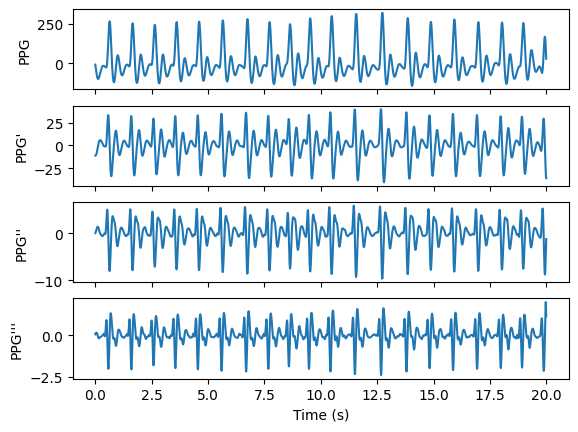

In [ ]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()

Store the derived signals in a class

In [ ]:
# Initialise the correction for fiducial points
corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Create a PPG class
s = PPG(signal)

Identify fiducial points:
__________________________

Initialise the fiducials package

In [ ]:
fpex = FP.FpCollection(s)

Extract fiducial points

In [ ]:
fiducials = fpex.get_fiducials(s)

Display the results

In [ ]:
print("Fiducial points:\n",fiducials + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)

Fiducial points:
                   on    sp    dn    dp   off     u     v     w     a     b  \
Index of pulse                                                               
0                  1    63    82    99   150    57    70    90    52    62   
1                150   165   185   202   248   159   172   193   154   164   
2                248   264   283   300   345   258   270   291   252   263   
3                345   360   380   397   444   354   367   387   349   359   
4                444   460   479   496   550   454   467   487   449   459   
5                550   565   584   601   659   559   572   592   554   564   
6                659   674   693   710   757   668   681   701   663   673   
7                757   773   792   809   827   766   779   800   761   771   
8                827   863   883   891   918   857   870   890   852   862   
9                918   953   972   989  1032   947   959   980   941   952   
10              1032  1048  1068  1084  1140  

Plot fiducial points
__________________________

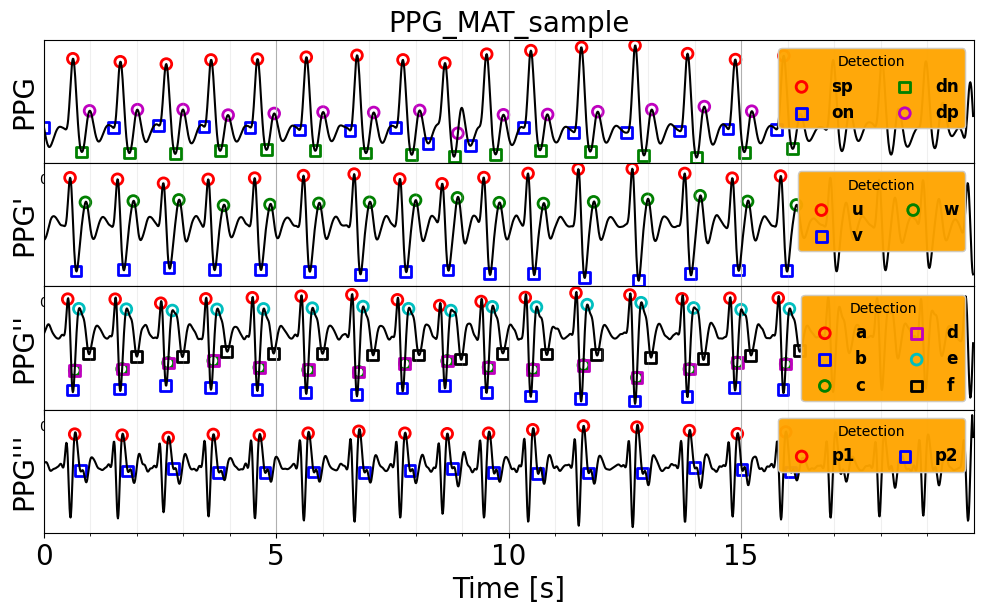

Figure has been saved in the "temp_dir".


In [ ]:
# Create a fiducials class
fp = Fiducials(fiducials)

# Plot fiducial points
plot_fiducials(s, fp, savingfolder, legend_fontsize=12)

Calculate PPG SQI:
_________________________

In [ ]:
# Get PPG SQI
ppgSQI = round(np.mean(SQI.get_ppgSQI(s.ppg, s.fs, fp.sp)) * 100, 2)
print('Mean PPG SQI: ', ppgSQI, '%')

Mean PPG SQI:  91.94 %


Calculate PPG biomarkers:
_________________________

Initialise the biomarkers package

In [ ]:
bmex = BM.BmCollection(s, fp)

Extract biomarkers

In [ ]:
bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()
tmp_keys=bm_stats.keys()
print('Statistics of the biomarkers:')
for i in tmp_keys: print(i,'\n',bm_stats[i])

# Create a biomarkers class
bm = Biomarkers(bm_defs, bm_vals, bm_stats)

Statistics of the biomarkers:
ppg_sig 
                     Tpi       Tpp      Tsys      Tdia       Tsp       Tdp  \
Statistics                                                                  
mean           1.075000  1.027857  0.414286  0.499286  0.221429  0.575714   
median         1.050000  1.025000  0.355000  0.510000  0.160000  0.520000   
std            0.134044  0.067842  0.129654  0.083876  0.129937  0.125340   
percentile_25  0.982500  0.990000  0.350000  0.462500  0.152500  0.520000   
percentile_75  1.120000  1.080000  0.375000  0.555000  0.185000  0.545000   
iqr            0.137500  0.090000  0.025000  0.092500  0.032500  0.025000   
skew           1.906116  0.085868  2.109811 -1.136631  2.129847  2.421852   
kurtosis       3.814671 -0.668628  3.419023  1.487462  3.528553  4.864830   
mad            0.090000  0.055000  0.095306  0.063673  0.095102  0.086122   

                     deltaT         Tsw10         Tsw25     Tsw33  ...  \
Statistics                            

Save PPG data:
______________

In [ ]:
# Save PPG struct, fiducial points, biomarkers
fp_new = Fiducials(fp.get_fp() + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)
save_data(s, fp_new, bm, savingformat, savingfolder)

Results have been saved into the "temp_dir".
